In [3]:
import os
import glob
import random
from collections import Counter, defaultdict
import numpy as np
import pandas as pd
import librosa
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.svm import SVC
from sklearn.model_selection import KFold, GridSearchCV, train_test_split, cross_val_score
from mtrf import TRF
from mtrf.stats import nested_crossval
from scipy.signal import resample as sci_resample
from scipy.ndimage import gaussian_filter1d
from pymer4.models import Lm, Lmer
import shap

sns.set_theme(
                style='white', 
                palette='Dark2',
                rc={"figure.dpi": 150}
            )
# plt.rcParams.update({
#     "figure.facecolor": (0.0, 0.0, 0.0, 0.0),
#     "axes.facecolor": (0.0, 0.0, 0.0, 0.0),
#     "legend.facecolor": (0.0, 0.0, 0.0, 0.0),
#     "savefig.facecolor": (0.0, 0.0, 0.0, 0.0),
# })

# Behavioral

In [4]:
mapping = {
            'M1': '1_M1_AM', 'M2': '1_M2_AM', 'M3': '1_M3_AM', 'M4': '1_M4_AM',
            'M5': '1_M2_PM', 'M6': '1_M1_PM', 'M7': '1_M3_PM', 'M8': '1_M4_PM',
            'M9': '2_M1_AM', 'M10': '2_M2_AM', 'M11': '2_M3_AM', 'M12': '2_M4_AM',
            'M13': '2_M1_PM', 'M14': '2_M2_PM', 'M15': '2_M3_PM', 'M16': '2_M4_PM',
            'F1': '1_F1_AM', 'F2': '1_F2_AM', 'F3': '1_F3_AM', 'F4': '1_F4_AM',
            'F5': '1_F1_PM', 'F6': '1_F2_PM', 'F7': '1_F3_PM', 'F8': '2_F1_AM',
            'F9': '2_F2_AM', 'F10': '2_F4_AM', 'F11': '2_F3_AM', 'F12': '2_F1_PM',
            'F13': '2_F2_PM', 'F14': '2_F3_PM', 'F15': '2_F4_PM'
        }

In [5]:
lst_df = []
for dir in (glob.glob(f'./data/responses/*')):
    if len(os.listdir(dir)) != 0:
        files = glob.glob(dir+'/*.csv')
        for i in range(len(files)):
            if len(files) == 4:
                if i != 0:
                    temp_df = pd.read_csv(files[i])
                    lst_df.append(temp_df)
            else:
                temp_df = pd.read_csv(files[i])
                lst_df.append(temp_df)
                
df = pd.concat(lst_df)

df['CorrectResp'] = df['Condition'].apply(lambda x: 'g' if x=='TRUE' else 'h')
df['Accuracy'] = (df['CorrectResp']==df['Resp'])
df['DisplayedDyad'] = df['AudioPath'].str.split('/').str[4]
df[['Age','Sex']] = df[['Sex','Age']].where(df['Subject'] > 5, df[['Age','Sex']].values)
df['VideoPath'] = df['VideoPath'].str.replace('\\', '/')
df['Condition'] = df['Condition'].apply(lambda x: 'true' if x=='TRUE' else 'fake')
df['SpeakerID'] = df.apply(lambda x: mapping.get(x['SpeakerID']), axis=1)
df['ListenerID'] = df.apply(lambda x: mapping.get(x['ListenerID']), axis=1)
df = df.drop('Date', axis=1).reset_index(drop=True)

## Age & gender

In [6]:
grouped = df.groupby('Subject')

N = df['Subject'].nunique()
age = grouped['Age'].apply(lambda x: x.iloc[0])
sex = grouped['Sex'].apply(lambda x: x.iloc[0]).value_counts()

print(f'N={N} (Male={sex["m"]+1}, Female={sex["f"]})')
print('Age: M={:.2f}, SD={:.2f}'.format(age.mean(), age.std()))

N=18 (Male=14, Female=4)
Age: M=25.78, SD=10.04


## Count of participant responses

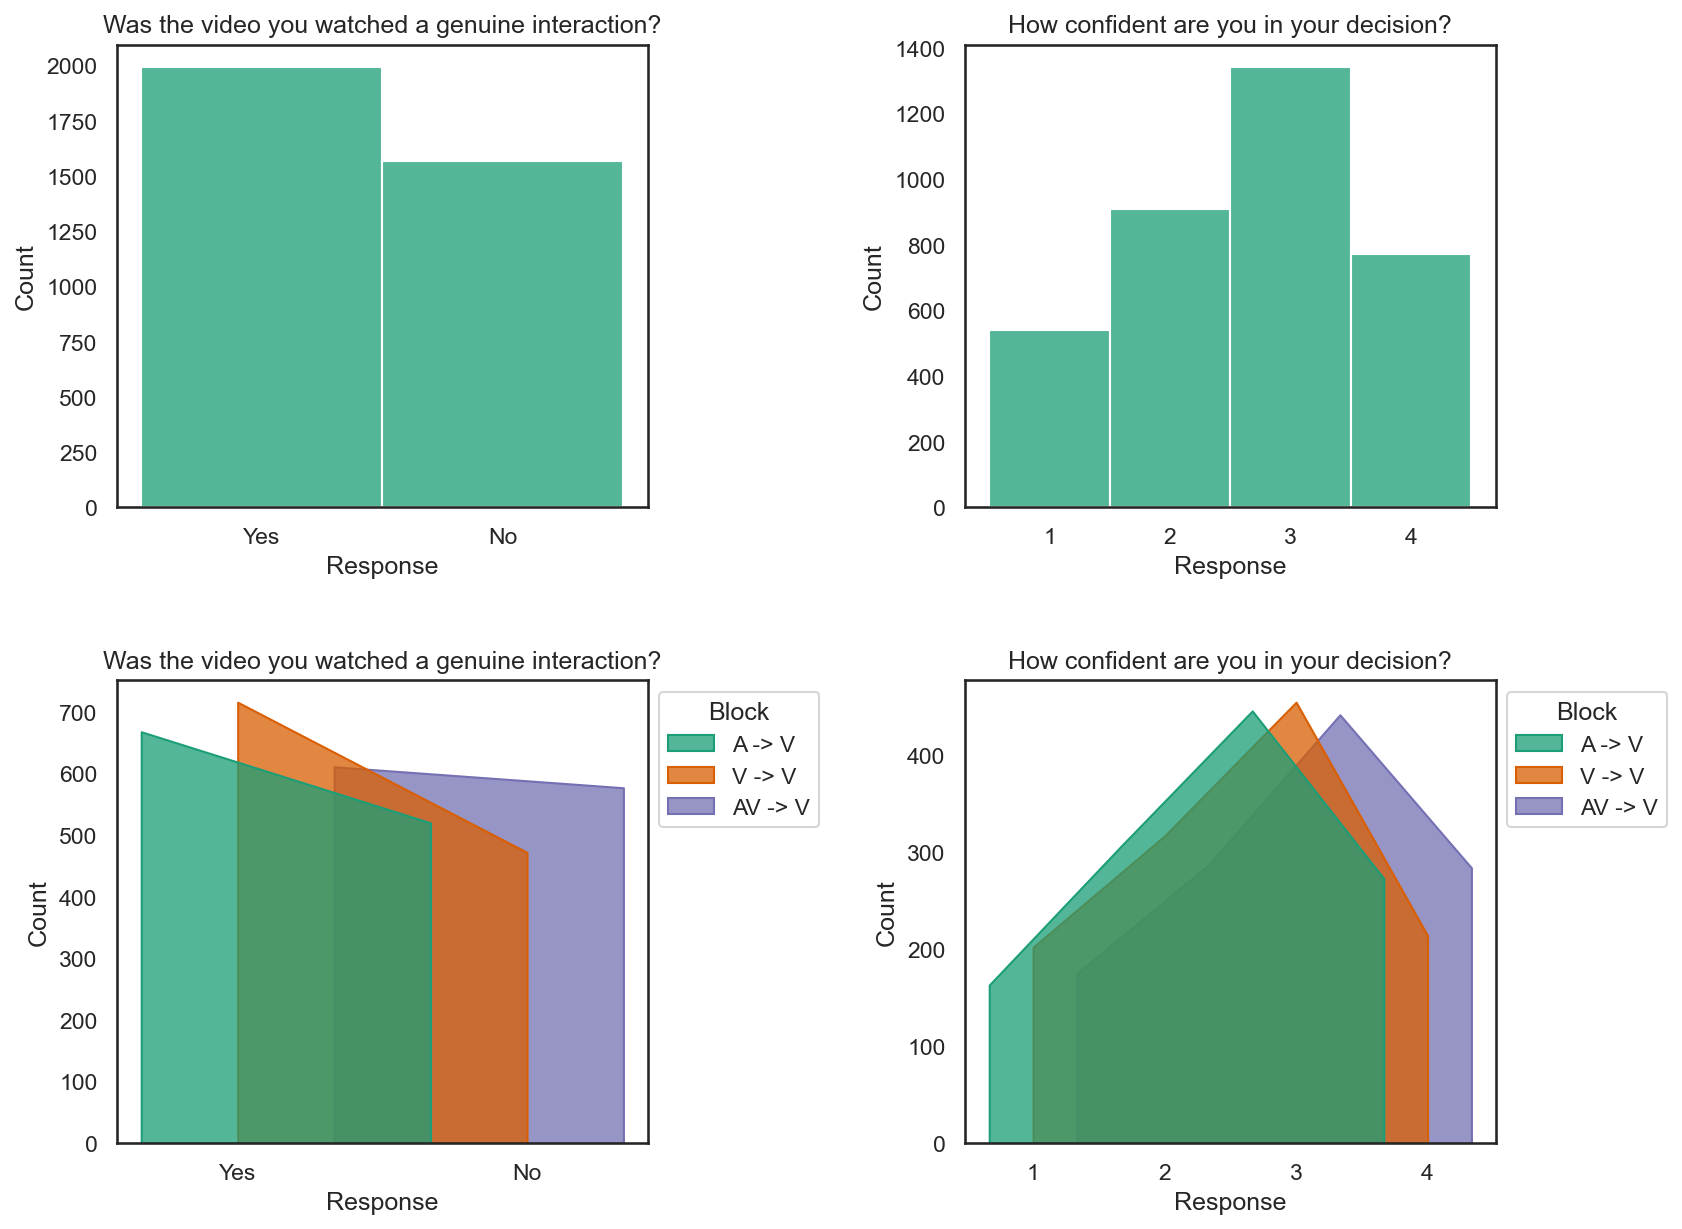

In [7]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))
plt.tight_layout(h_pad=5, w_pad=10)
sns.histplot(x='Resp', data=df, ax=axs[0, 0])
axs[0, 0].set_xticks([0, 1], labels=['Yes', 'No'])
axs[0, 0].set_xlabel('Response')
axs[0, 0].set_title('Was the video you watched a genuine interaction?')

sns.histplot(x='LikertResp', data=df, bins=4, discrete=True, ax=axs[0, 1])
axs[0, 1].set_xticks([1, 2, 3, 4], labels=['1', '2', '3', '4'])
axs[0, 1].set_xlabel('Response')
axs[0, 1].set_title('How confident are you in your decision?')

sns.histplot(x='Resp', hue='Block', data=df, ax=axs[1, 0], multiple='dodge', element='poly')
axs[1, 0].set_xticks([0, 1], labels=['Yes', 'No'])
axs[1, 0].set_xlabel('Response')
for t, l in zip(axs[1, 0].legend_.texts, ['A -> V', 'V -> V', 'AV -> V']):
    t.set_text(l)
axs[1, 0].set_title('Was the video you watched a genuine interaction?')
sns.move_legend(axs[1, 0], "upper left", bbox_to_anchor=(1, 1))

sns.histplot(x='LikertResp', hue='Block', data=df, bins=4, discrete=True, ax=axs[1, 1], multiple='dodge', element='poly')
axs[1, 1].set_xticks([1, 2, 3, 4], labels=['1', '2', '3', '4'])
axs[1, 1].set_xlabel('Response')
for t, l in zip(axs[1, 1].legend_.texts, ['A -> V', 'V -> V', 'AV -> V']):
    t.set_text(l)
axs[1, 1].set_title('How confident are you in your decision?')
sns.move_legend(axs[1, 1], "upper left", bbox_to_anchor=(1, 1))

## Are participants above chance at the task?

In [8]:
def get_stats(data=None, type=None):

    hit = len(data[(data['Condition'] == 'true') & (data['Resp'] == 'g')])
    cr = len(data[(data['Condition'] == 'fake') & (data['Resp'] == 'h')])
    miss = len(data[(data['Condition'] == 'true') & (data['Resp'] == 'h')])
    fa = len(data[((data['Condition'] == 'fake') & (data['Resp'] == 'g'))])

    if type == 'sdt':
        hit_rate = hit / (hit+miss)
        fa_rate = fa / (fa+cr)
        d_prime = stats.norm.ppf(hit_rate) - stats.norm.ppf(fa_rate)

        res = pd.Series({
                            'Hit Rate':hit_rate, 
                            'False Alarm Rate':fa_rate, 
                            'd prime':d_prime
                        })
    elif type == 'accuracy':
        res = (hit+cr)/len(data)

    return res

### Accuracy

In [9]:
def print_ttest(res, text):
    print(f'{text}: t({res.df})={res.statistic:.2f}, p={res.pvalue:.2f}')

t-test for above chance accuracy: t(17)=10.86, p=0.00
t-test between V -> V and A -> V: t(17)=-4.44, p=0.00
t-test between V -> V and AV -> V: t(17)=-4.22, p=0.00
t-test between A -> V and AV -> V: t(17)=0.91, p=0.38


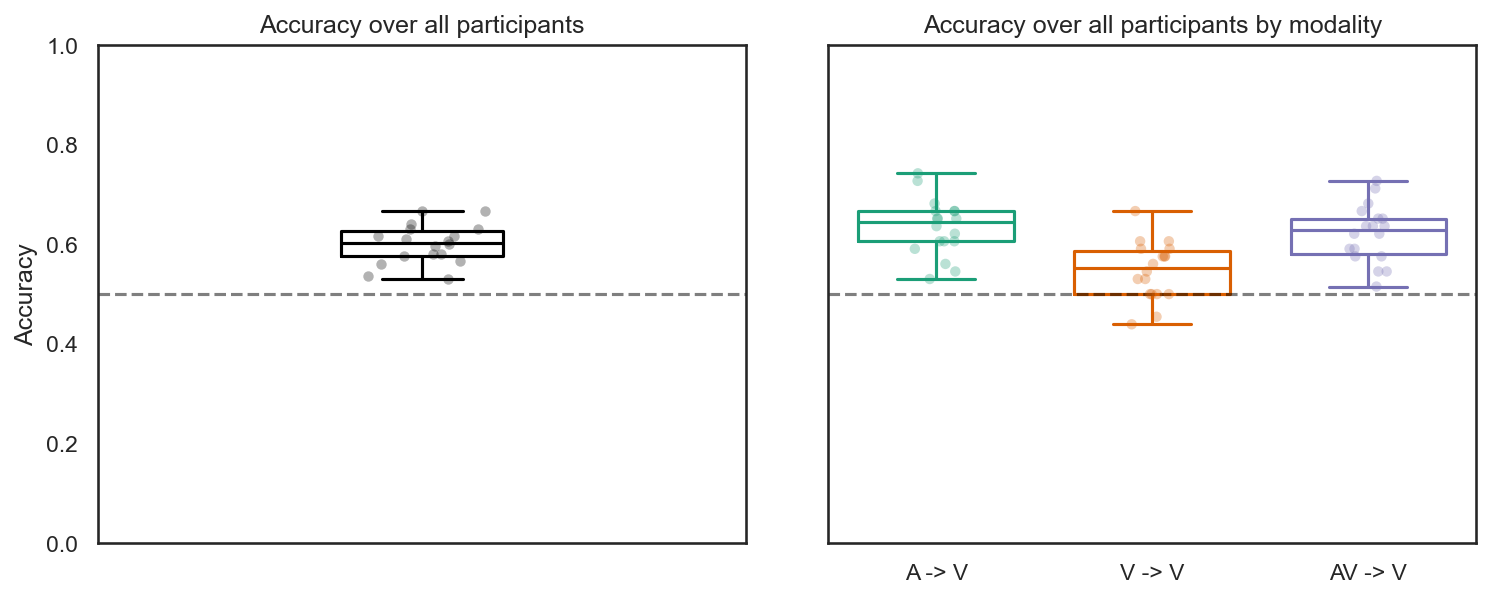

In [10]:
df_accuracy = df.groupby('Subject').apply(lambda x: pd.Series({'accuracy': get_stats(x, 'accuracy')}))
df_accuracy_block = df.groupby(['Subject', 'Block'], as_index=False).apply(lambda x: pd.Series({'accuracy': get_stats(x, 'accuracy')}))

fig, axs = plt.subplots(ncols=2, sharey=True, figsize=(10, 4))
plt.tight_layout(w_pad=2)
sns.boxplot(y='accuracy', data=df_accuracy, width=0.25, color='k', fill=False, ax=axs[0])
sns.stripplot(y='accuracy', data=df_accuracy, alpha=0.3, color='k', ax=axs[0])
axs[0].set_ylim(0, 1)
axs[0].set_ylabel('Accuracy')
axs[0].axhline(y=0.5, c='k', ls='--', alpha=0.5)
axs[0].set_title('Accuracy over all participants')

sns.boxplot(y='accuracy', x='Block', hue='Block', data=df_accuracy_block, fill=False, gap=0.1)
sns.stripplot(y='accuracy', x='Block', hue='Block', data=df_accuracy_block, alpha=0.3, legend=False)
axs[1].set_ylim(0, 1)
axs[1].set_ylabel('Accuracy')
axs[1].set_xlabel('')
axs[1].axhline(y=0.5, c='k', ls='--', alpha=0.5)
axs[1].set_xticks([0, 1, 2], ['A -> V', 'V -> V', 'AV -> V'])
axs[1].set_title('Accuracy over all participants by modality')

res = stats.ttest_1samp(df_accuracy['accuracy'].to_numpy(), 0.5)
print_ttest(res, text='t-test for above chance accuracy')

vv_av = stats.ttest_rel(
    df_accuracy_block[df_accuracy_block['Block']=='vv']['accuracy'].to_numpy(), 
    df_accuracy_block[df_accuracy_block['Block']=='va']['accuracy'].to_numpy()
)
print_ttest(vv_av, text='t-test between V -> V and A -> V')

vv_avv = stats.ttest_rel(
    df_accuracy_block[df_accuracy_block['Block']=='vv']['accuracy'].to_numpy(), 
    df_accuracy_block[df_accuracy_block['Block']=='vva']['accuracy'].to_numpy()
)
print_ttest(vv_avv, text='t-test between V -> V and AV -> V')

av_avv = stats.ttest_rel(
    df_accuracy_block[df_accuracy_block['Block']=='va']['accuracy'].to_numpy(), 
    df_accuracy_block[df_accuracy_block['Block']=='vva']['accuracy'].to_numpy()
)
print_ttest(av_avv, text='t-test between A -> V and AV -> V')

### SDT

t-test for above chance dprime: t(17)=10.23, p=0.00
t-test between V -> V and A -> V dprime: t(17)=-4.31, p=0.00
t-test between V -> V and AV -> V dprime: t(17)=-4.11, p=0.00
t-test between A -> V and AV -> V dprime: t(17)=0.33, p=0.74


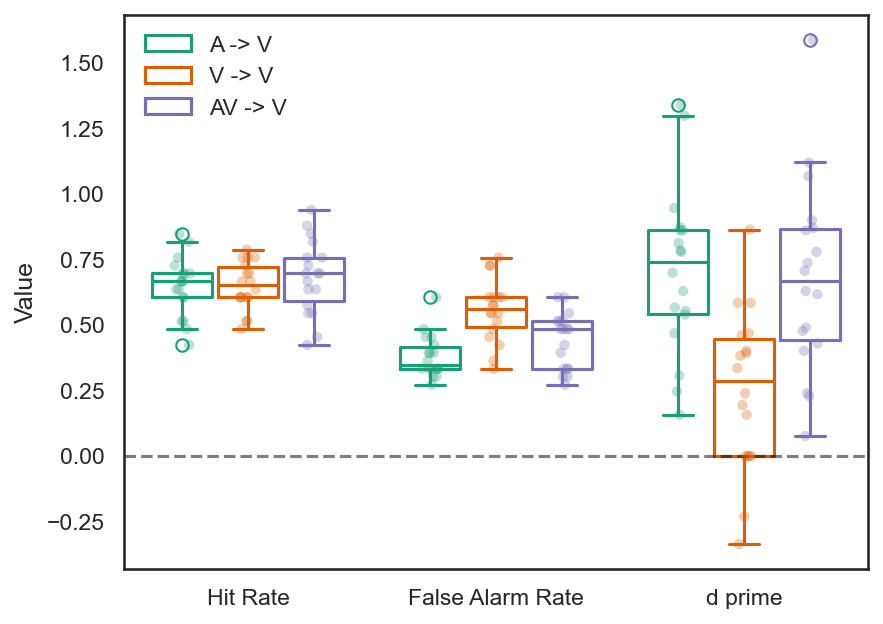

In [11]:
df_sdt = df.groupby(['Subject', 'Block'], as_index=False).apply(
            lambda x: get_stats(x, 'sdt')).melt(
            id_vars=['Subject', 'Block'], var_name='Measure').reset_index(drop=True)

# fig, axs = plt.subplots(ncols=2, figsize=(10, 4))
# plt.tight_layout(w_pad=3)
# sns.boxplot(y='value', data=df_sdt[df_sdt['Measure']=='d prime'].groupby('Subject').mean('value'), fill=False, width=0.2, color='black', ax=axs[0])
# sns.stripplot(y='value', data=df_sdt[df_sdt['Measure']=='d prime'].groupby('Subject').mean('value'), alpha=0.3, dodge=True, legend=False, color='black', ax=axs[0])
# axs[0].set_xticks([])
# axs[0].set_xlabel('')
# axs[0].set_ylabel("d'")
# axs[0].axhline(y=0, linestyle='--', color='k', alpha=0.5)
# axs[0].set_title("d' over all participants")

# sns.boxplot(y='value', x='Measure', hue='Block', data=df_sdt, fill=False, gap=.1, ax=axs[1])
# sns.stripplot(y='value', x='Measure', hue='Block', data=df_sdt, alpha=0.3, dodge=True, legend=False, ax=axs[1])
# axs[1].legend_.set_title('Modality')
# axs[1].legend(frameon=False)
# for t, l in zip(axs[1].legend_.texts, ['A -> V', 'V -> V', 'AV -> V']):
#     t.set_text(l)
# axs[1].set_xlabel('')
# axs[1].set_ylabel('Value')
# axs[1].axhline(y=0, linestyle='--', color='k', alpha=0.5)

sns.boxplot(y='value', x='Measure', hue='Block', data=df_sdt, fill=False, gap=.1)
sns.stripplot(y='value', x='Measure', hue='Block', data=df_sdt, alpha=0.3, dodge=True, legend=False)
plt.gca().legend_.set_title('Modality')
plt.legend(frameon=False)
for t, l in zip(plt.gca().legend_.texts, ['A -> V', 'V -> V', 'AV -> V']):
    t.set_text(l)
plt.xlabel('')
plt.ylabel('Value')
plt.axhline(y=0, linestyle='--', color='k', alpha=0.5)

res = stats.ttest_1samp(
    df_sdt[df_sdt['Measure']=='d prime'].groupby('Subject').mean('value')['value'].to_numpy(), 
    0
)
print_ttest(res, text='t-test for above chance dprime')

vv_av = stats.ttest_rel(
    df_sdt[(df_sdt['Measure']=='d prime') & (df_sdt['Block']=='vv')]['value'], 
    df_sdt[(df_sdt['Measure']=='d prime') & (df_sdt['Block']=='va')]['value']
)
print_ttest(vv_av, text='t-test between V -> V and A -> V dprime')

vv_avv = stats.ttest_rel(
    df_sdt[(df_sdt['Measure']=='d prime') & (df_sdt['Block']=='vv')]['value'], 
    df_sdt[(df_sdt['Measure']=='d prime') & (df_sdt['Block']=='vva')]['value']
)
print_ttest(vv_avv, text='t-test between V -> V and AV -> V dprime')

av_avv = stats.ttest_rel(
    df_sdt[(df_sdt['Measure']=='d prime') & (df_sdt['Block']=='va')]['value'], 
    df_sdt[(df_sdt['Measure']=='d prime') & (df_sdt['Block']=='vva')]['value']
)
print_ttest(av_avv, text='t-test between A -> V and AV -> V dprime')

## Accuracy & confidence rating vs. trial duration

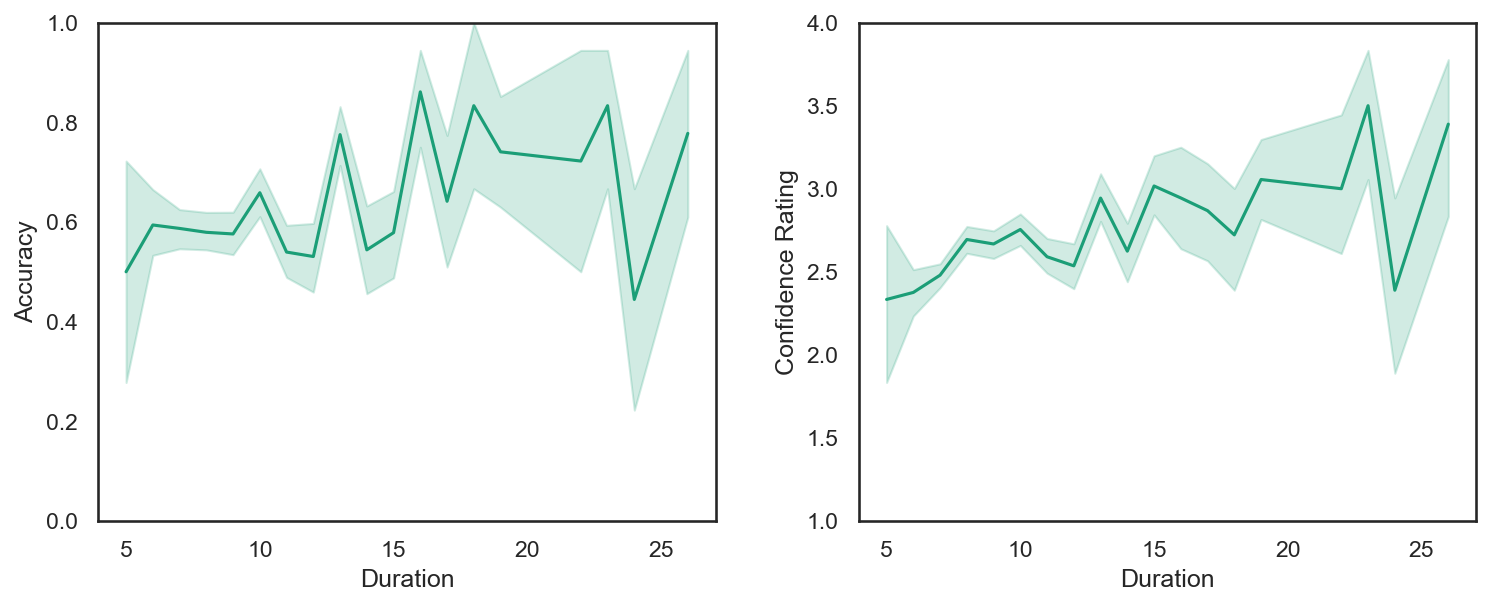

In [12]:
fig, axs = plt.subplots(ncols=2, sharex=True, figsize=(10, 4))
plt.tight_layout(w_pad=3)
sns.lineplot(y='Accuracy', x='Duration', data=df, ax=axs[0])
axs[0].set_ylim(0, 1)

sns.lineplot(y='LikertResp', x='Duration', data=df, ax=axs[1])
axs[1].set_ylim(1, 4)
axs[1].set_ylabel('Confidence Rating');

## Distribution of accuracy over dyads

Text(0.5, 1.0, 'Distribution of dyad accuracies')

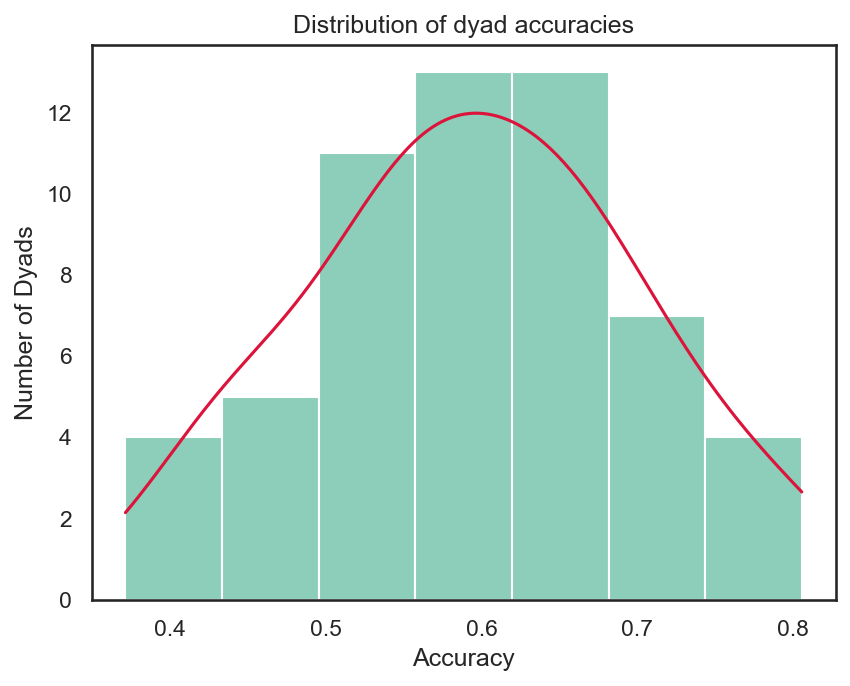

In [13]:
grouped = df.groupby(df['DisplayedDyad'])
df_dyad = grouped.apply(lambda x: get_stats(x, 'accuracy')).reset_index(name='Accuracy')
df_dyad['NumTrials'] = grouped.apply(lambda x: len(x)).reset_index(name='NumTrials')['NumTrials']
df_dyad['Stims'] = grouped.apply(lambda x: x['VideoPath'].to_numpy()).reset_index(name='Stims')['Stims']
df_dyad

ax = sns.histplot(data=df_dyad, x='Accuracy', kde=True)
ax.lines[0].set_color('crimson')
ax.set_ylabel('Number of Dyads')
ax.set_title('Distribution of dyad accuracies')

# Computational

In [14]:
store = {
    'sr': 30,
    'aus': ["AU12","AU14","AU15", "AU17","AU23","AU24","AU25","AU26","AU28","AU43","Pitch"],
    'au_gifs': ["https://imotions.com/wp-content/uploads/2022/10/AU12.gif", "https://imotions.com/wp-content/uploads/2022/10/AU14-dimpler.gif", 
                "https://imotions.com/wp-content/uploads/2022/10/AU15.gif", "https://imotions.com/wp-content/uploads/2022/10/AU17.gif", 
                "https://imotions.com/wp-content/uploads/2022/10/AU23-lip-tightener.gif", "https://imotions.com/wp-content/uploads/2022/10/AU24.gif", 
                "https://imotions.com/wp-content/uploads/2022/10/AU25-lips-part.gif", "https://imotions.com/wp-content/uploads/2022/10/AU26-with-25.gif", 
                "https://imotions.com/wp-content/uploads/2022/10/AU28-with-26.gif", "https://imotions.com/wp-content/uploads/2022/10/AU43-eyes-closed.gif",
                "https://imotions.com/wp-content/uploads/2022/10/AU54-head-down.gif"],
    'modality': 'va',
    'audio_type': 'auditory_nerve',
    'trf_min_lag': 0,
    'trf_max_lag': 3
}

In [15]:
df_trials = pd.read_csv('./stim/all_trials_dispDyad.csv')
df_trials = df_trials[(df_trials['Modality'] == store.get('modality'))].reset_index(drop=True).drop('Unnamed: 0', axis='columns')

df_trials['VideoPath'] = df_trials['VideoPath'].str.replace('\\', '/')
df_trials['Condition'] = df_trials['Condition'].apply(lambda x: 'true' if x=='TRUE' else 'fake')
df_trials['SpeakerID'] = df_trials.apply(lambda x: mapping.get(x['SpeakerID']), axis=1)
df_trials['ListenerID'] = df_trials.apply(lambda x: mapping.get(x['ListenerID']), axis=1)

df_trials = df_trials[~df_trials['VideoPath'].isin(['./stim/processed_extracts/fake/8/4_5_va.mov', './stim/processed_extracts/fake/9/1_3_va.mov'])]

## Utility functions

In [16]:
def resample_signal(signal, length):
    signal_resampled = sci_resample(signal, len(np.arange(0, length, 1/store.get('sr'))))
    signal_resampled = gaussian_filter1d(signal_resampled, sigma=2)

    standardize = StandardScaler()
    signal_resampled = standardize.fit_transform(signal_resampled.reshape(-1, 1))

    return signal_resampled.flatten()


def get_data(type, file, length, au=None):
    match type:
        case 'rms':
            audio, audio_sr = librosa.load(file)
            rms_win = 0.5
            rms_hop = 1/store.get('sr') 
            rms = librosa.feature.rms(y=audio, frame_length=int(store.get('sr')*rms_win), hop_length=int(store.get('sr')*rms_hop))
            data=rms[0]
        case 'auditory_nerve':
            file = file.replace(os.sep, '/')
            df = pd.read_csv(file, usecols=[1])
            data = df.to_numpy().flatten()
        case 'au':
            data = pd.read_csv(file)[au].to_numpy()
        case _:
            raise ValueError(f"{type} not a valid value for type. Valid values are: ['rms', 'auditory_nerve', 'au']")
    
    data_resampled = resample_signal(data, length)

    return data_resampled

## Train TRF on True trials

In [17]:
def trial_info(trial):
    video_path = trial['VideoPath']
    audio_path = trial['AudioPath']
    disp_dyad = trial['DisplayedDyad']
    duration = trial['Duration']
    condition = trial['Condition']
    au_path = f"./data/aus_pure/va/{condition}/{disp_dyad}_{video_path.split('/')[-1].replace('.mov', '_aus.csv')}"
    an_path = audio_path.replace('_audio.wav', '.csv').replace('audio', 'audio_carney')

    return {'VideoPath': video_path, 'AudioPath': audio_path, 'DisplayedDyad': disp_dyad, 
            'Duration': duration, 'Condition': condition, 'AUPath': au_path, 'ANPath': an_path}


def prepare_input(data, condition, au):
    stims = []
    resps = []
        
    for idx, row in data[data['Condition']==condition].iterrows():
        info = trial_info(row)
        if os.path.exists(info['AUPath']):
            stim = get_data(type=store.get('audio_type'), file=info['ANPath'], length=info['Duration'])
            stims.append(stim)

            resp = get_data(type='au', file=info['AUPath'], length=info['Duration'], au=au)
            resps.append(resp)

    return stims, resps

In [18]:
trfs = []
regularization = np.logspace(-1, 6, 10)

for au in store.get('aus'):
    stims, resps = prepare_input(data=df_trials, condition='true', au=au)
    trf = TRF(direction=1)
    r_unbiased, best_regularization = nested_crossval(
        model=trf, 
        stimulus=stims, 
        response=resps, 
        fs=store.get('sr'), 
        tmin=store.get('trf_min_lag'), 
        tmax=store.get('trf_max_lag'), 
        regularization=regularization, 
        k=5, 
        verbose=False,
        seed=1
    )
    trf.train(
                stimulus=stims, 
                response=resps, 
                fs=store.get('sr'), 
                tmin=store.get('trf_min_lag'), 
                tmax=store.get('trf_max_lag'), 
                regularization=best_regularization,
                seed=1
    )
    trfs.append(trf)

Cross-validating[##################################################] 100/100..] 0/5

Cross-validating[##################################################] 100/100..] 1/5

Cross-validating[##################################################] 100/100..] 2/5

Cross-validating[##################################################] 100/100..] 3/5

Cross-validating[##################################################] 100/100..] 4/5

Hyperparameter optimization[##################################################] 5/5

Cross-validating[##################################################] 100/100..] 0/5

Cross-validating[##################################################] 100/100..] 1/5

Cross-validating[##################################################] 100/100..] 2/5

Cross-validating[##################################################] 100/100..] 3/5

Cross-validating[##################################################] 100/100..] 4/5

Hyperparameter optimization[#####################################

## Predict responses to both True & Fake trials

In [19]:
def predict_response(data, trfs):
    aus = []
    correlations = []
    predictions = []

    for i, row in data.iterrows():
        info = trial_info(row)
        for idx, au in enumerate(store.get('aus')):
            if os.path.exists(info['AUPath']):
                stim = get_data(type=store.get('audio_type'), file=info['ANPath'], length=info['Duration'])
                resp = get_data(type='au', file=info['AUPath'], length=info['Duration'], au=au)

                prediction, correlation = trfs[idx].predict(stimulus=stim, response=resp)

                aus.append(au)
                predictions.append(prediction)
                correlations.append(correlation)
            else:
                print(f"Missing file: {info['AUPath']}. Skipping...")

    return aus, predictions, correlations

In [20]:
aus, predictions, correlations = predict_response(df_trials, trfs)

In [21]:
# reshape list of AUs to (198, 11) to fit in the DataFrame as a column
df_trials['AU'] = list(np.reshape(aus, (len(df_trials), len(trfs))))
df_trials['Pearsonr'] = list(np.reshape(correlations, (len(df_trials), len(trfs))).astype(float))
df_trials = df_trials.explode(column=['AU', 'Pearsonr'])
df_trials['Prediction'] = predictions
df_trials

,SpeakerDyad,ListenerDyad,SpeakerExtract,ListenerExtract,SpeakerID,ListenerID,VideoPath,AudioPath,Condition,Modality,SpeakerSex,Duration,DisplayedDyad,AU,Pearsonr,Prediction
0,1,1,3,3,1_F1_AM,1_M1_AM,./stim/processed_extracts/true/1/3_va.mov,./stim/processed_extracts/audio/1/3_audio.wav,true,va,F,26,1,AU12,0.081324,"[[[0.004966987412509277], [0.00720985138648936..."
0,1,1,3,3,1_F1_AM,1_M1_AM,./stim/processed_extracts/true/1/3_va.mov,./stim/processed_extracts/audio/1/3_audio.wav,true,va,F,26,1,AU14,0.127025,"[[[-0.02141062721119634], [-0.0049527386903597..."
0,1,1,3,3,1_F1_AM,1_M1_AM,./stim/processed_extracts/true/1/3_va.mov,./stim/processed_extracts/audio/1/3_audio.wav,true,va,F,26,1,AU15,0.10302,"[[[-1.5381891180382368e-07], [-1.4214540348717..."
0,1,1,3,3,1_F1_AM,1_M1_AM,./stim/processed_extracts/true/1/3_va.mov,./stim/processed_extracts/audio/1/3_audio.wav,true,va,F,26,1,AU17,0.072651,"[[[-0.01552273223220624], [-0.0156345937946571..."
0,1,1,3,3,1_F1_AM,1_M1_AM,./stim/processed_extracts/true/1/3_va.mov,./stim/processed_extracts/audio/1/3_audio.wav,true,va,F,26,1,AU23,0.13576,"[[[-0.0017524973471346875], [-0.00175538684940..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199,59,55,2,3,2_M4_PM,2_F4_PM,./stim/processed_extracts/fake_ad/60/55_3_59_2...,./stim/processed_extracts/audio/60/55_3_59_2_a...,fake,va,M,7,60,AU25,-0.149003,"[[[0.008025578167083844], [0.01220909329907835..."
199,59,55,2,3,2_M4_PM,2_F4_PM,./stim/processed_extracts/fake_ad/60/55_3_59_2...,./stim/processed_extracts/audio/60/55_3_59_2_a...,fake,va,M,7,60,AU26,0.06716,"[[[-0.001352099441256721], [-0.003853222901304..."
199,59,55,2,3,2_M4_PM,2_F4_PM,./stim/processed_extracts/fake_ad/60/55_3_59_2...,./stim/processed_extracts/audio/60/55_3_59_2_a...,fake,va,M,7,60,AU28,0.368028,"[[[0.1278625237923903], [0.04634471768733102],..."
199,59,55,2,3,2_M4_PM,2_F4_PM,./stim/processed_extracts/fake_ad/60/55_3_59_2...,./stim/processed_extracts/audio/60/55_3_59_2_a...,fake,va,M,7,60,AU43,-0.254158,"[[[-3.951996265356724e-07], [-4.65352324129700..."


## Plot two random input-output pairs

In [ ]:
times = np.arange(0, 7, 1/store.get('sr'))
sns.lineplot(y=get_data(type='auditory_nerve', file="./stim/processed_extracts/audio_carney/4/4.csv", length=7), x=times)
plt.xlabel('Time')
plt.ylabel('Amplitude')

In [ ]:
sns.lineplot(y=get_data(type='au', file='./data/aus_pure/va/true/4_4_va_aus.csv', length=7, au='AU43'), x=times, color='#b74200')
plt.xlabel('Time')
plt.ylabel('Amplitude')

In [ ]:
sns.lineplot(y=get_data(type='auditory_nerve', file="./stim/processed_extracts/audio_carney/16/4.csv", length=7), x=times)
plt.xlabel('Time')
plt.ylabel('Amplitude')

In [ ]:
sns.lineplot(y=get_data(type='au', file='./data/aus_pure/va/true/16_4_va_aus.csv', length=7, au='AU43'), color='#b74200', x=times)
plt.xlabel('Time')
plt.ylabel('Amplitude')

## Plot best true trial and worst fake trial (for posters)

In [ ]:
test = df_trials[(df_trials['AU']=='AU43') & (df_trials['Condition']=='true')].reset_index(drop=True)
test.iloc[test.Pearsonr.idxmax()]

In [ ]:
video_path1 = " ./stim/processed_extracts/true/29/1_va.mov"
audio_path1 =  " ./stim/processed_extracts/audio/29/1_audio.wav"

au_path1 = f"./data/aus_pure/va/true/29_{video_path1.split('/')[-1].replace('.mov', '_aus.csv')}"
an_path1 = audio_path1.replace('_audio.wav', '.csv').replace('audio', 'audio_carney')

In [ ]:
times = np.arange(0, 6, 1/store.get('sr'))
sns.lineplot(y=get_data(type='auditory_nerve', file="./stim/processed_extracts/audio_carney/29/1.csv", length=6), x=times)
plt.xlabel('Time')
plt.ylabel('Amplitude')

In [ ]:
sns.lineplot(y=get_data(type='au', file=au_path1, length=6, au='AU43'), color='#b74200', x=times)
plt.xlabel('Time')
plt.ylabel('Amplitude')

In [ ]:
sns.lineplot(y=get_data(type='au', file=au_path1, length=6, au='AU43'), color='#b74200', x=times, label='Actual', linestyle='--', alpha=0.5)
sns.lineplot(y=StandardScaler().fit_transform(np.asarray(test.iloc[test.Pearsonr.idxmax()].Prediction).reshape(-1, 1)).flatten(), x=times, label='Predicted', color='#b74200')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()
plt.axhline(y=0, c='k', linestyle='--', alpha=0.5)

In [ ]:
test1 = df_trials[(df_trials['AU']=='AU43') & (df_trials['Condition']=='fake')].reset_index(drop=True)
test1.iloc[94]

In [ ]:
video_path = "./stim/processed_extracts/fake_ad/57/49_4_51_2_va.mov"
audio_path =  "./stim/processed_extracts/audio/57/49_4_51_2_audio.wav"

au_path = f"./data/aus_pure/va/fake/57_{video_path.split('/')[-1].replace('.mov', '_aus.csv')}"
an_path = audio_path.replace('_audio.wav', '.csv').replace('audio', 'audio_carney')

In [ ]:
times = np.arange(0, 7, 1/store.get('sr'))
sns.lineplot(y=get_data(type='auditory_nerve', file=an_path, length=7), x=times)
plt.xlabel('Time')
plt.ylabel('Amplitude')

In [ ]:
sns.lineplot(y=get_data(type='au', file=au_path, length=7, au='AU43'), color='#b74200', x=times)
plt.xlabel('Time')
plt.ylabel('Amplitude')

In [ ]:
sns.lineplot(y=get_data(type='au', file=au_path, length=7, au='AU43'), color='#b74200', x=times, label='Actual', linestyle='--', alpha=0.5)
sns.lineplot(y=StandardScaler().fit_transform(np.asarray(test1.iloc[94].Prediction).reshape(-1, 1)).flatten(), x=times, label='Predicted', color='#b74200')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()
plt.axhline(y=0, c='k', linestyle='--', alpha=0.5)

## Plot TRFs

In [22]:
def plot_trf(direction, trf, channel=None, feature=None, axes=None, show=True, kind="line"):
    """
    Arguments:
        channel (None | int | str): Channel selection. If None, all channels will be used. If an integer, the channel at that index will be used. If 'avg' or 'gfp' , the average or standard deviation across channels will be computed.
        feature (None | int | str): Feature selection. If None, all features will be used. If an integer, the feature at that index will be used. If 'avg' , the average across features will be computed.
        axes (matplotlib.axes.Axes): Axis to plot to. If None is provided (default) generate a new plot.
    """
    if axes is None:
        fig, ax = plt.subplots(figsize=(6, 6))
    else:
        fig, ax = None, axes  # dont create a new figure
    weights = trf.weights
    # select channel and or feature
    if weights.shape[0] == 1:
        feature = 0
    if weights.shape[-1] == 1:
        channel = 0
    if channel is None and feature is None:
        raise ValueError("You must specify a subset of channels or features!")
    if feature is not None:
        image_ylabel = "channel"
        if isinstance(feature, int):
            weights = weights[feature, :, :]
        elif feature == "avg":
            weights = weights.mean(axis=0)
        else:
            raise ValueError('Argument `feature` must be an integer or "avg"!')
    if channel is not None:
        image_ylabel = "feature"
        if isinstance(channel, int):
            weights = weights.T[channel].T
        elif channel == "avg":
            weights = weights.mean(axis=-1)
        elif channel == "gfp":
            weights = weights.std(axis=-1)
        else:
            raise ValueError(
                'Argument `channel` must be an integer, "avg" or "gfp"'
            )
        weights = weights.T  # transpose so first dimension is time
    # plot the result
    scaler = StandardScaler()
    if kind == "line":
        # ax.plot(
        #     trf.times.flatten(), scaler.fit_transform(weights.reshape(-1, 1)), linewidth=2 - 0.01 * weights.shape[-1]
        # )
        ax.plot(
            trf.times.flatten(), scaler.fit_transform(weights.reshape(-1, 1)), linewidth=2, color='k'
        )
        ax.set(
            xlabel="Time lag[s]",
            ylabel="Amplitude [a.u.]",
            xlim=(trf.times.min(), trf.times.max()),
            ylim=(-2.5, 2.5)
        )
        ax.axhline(y=0, color='k', linestyle='--', alpha=0.25)
    if show is True:
        plt.show()
    if fig is not None:
        return fig

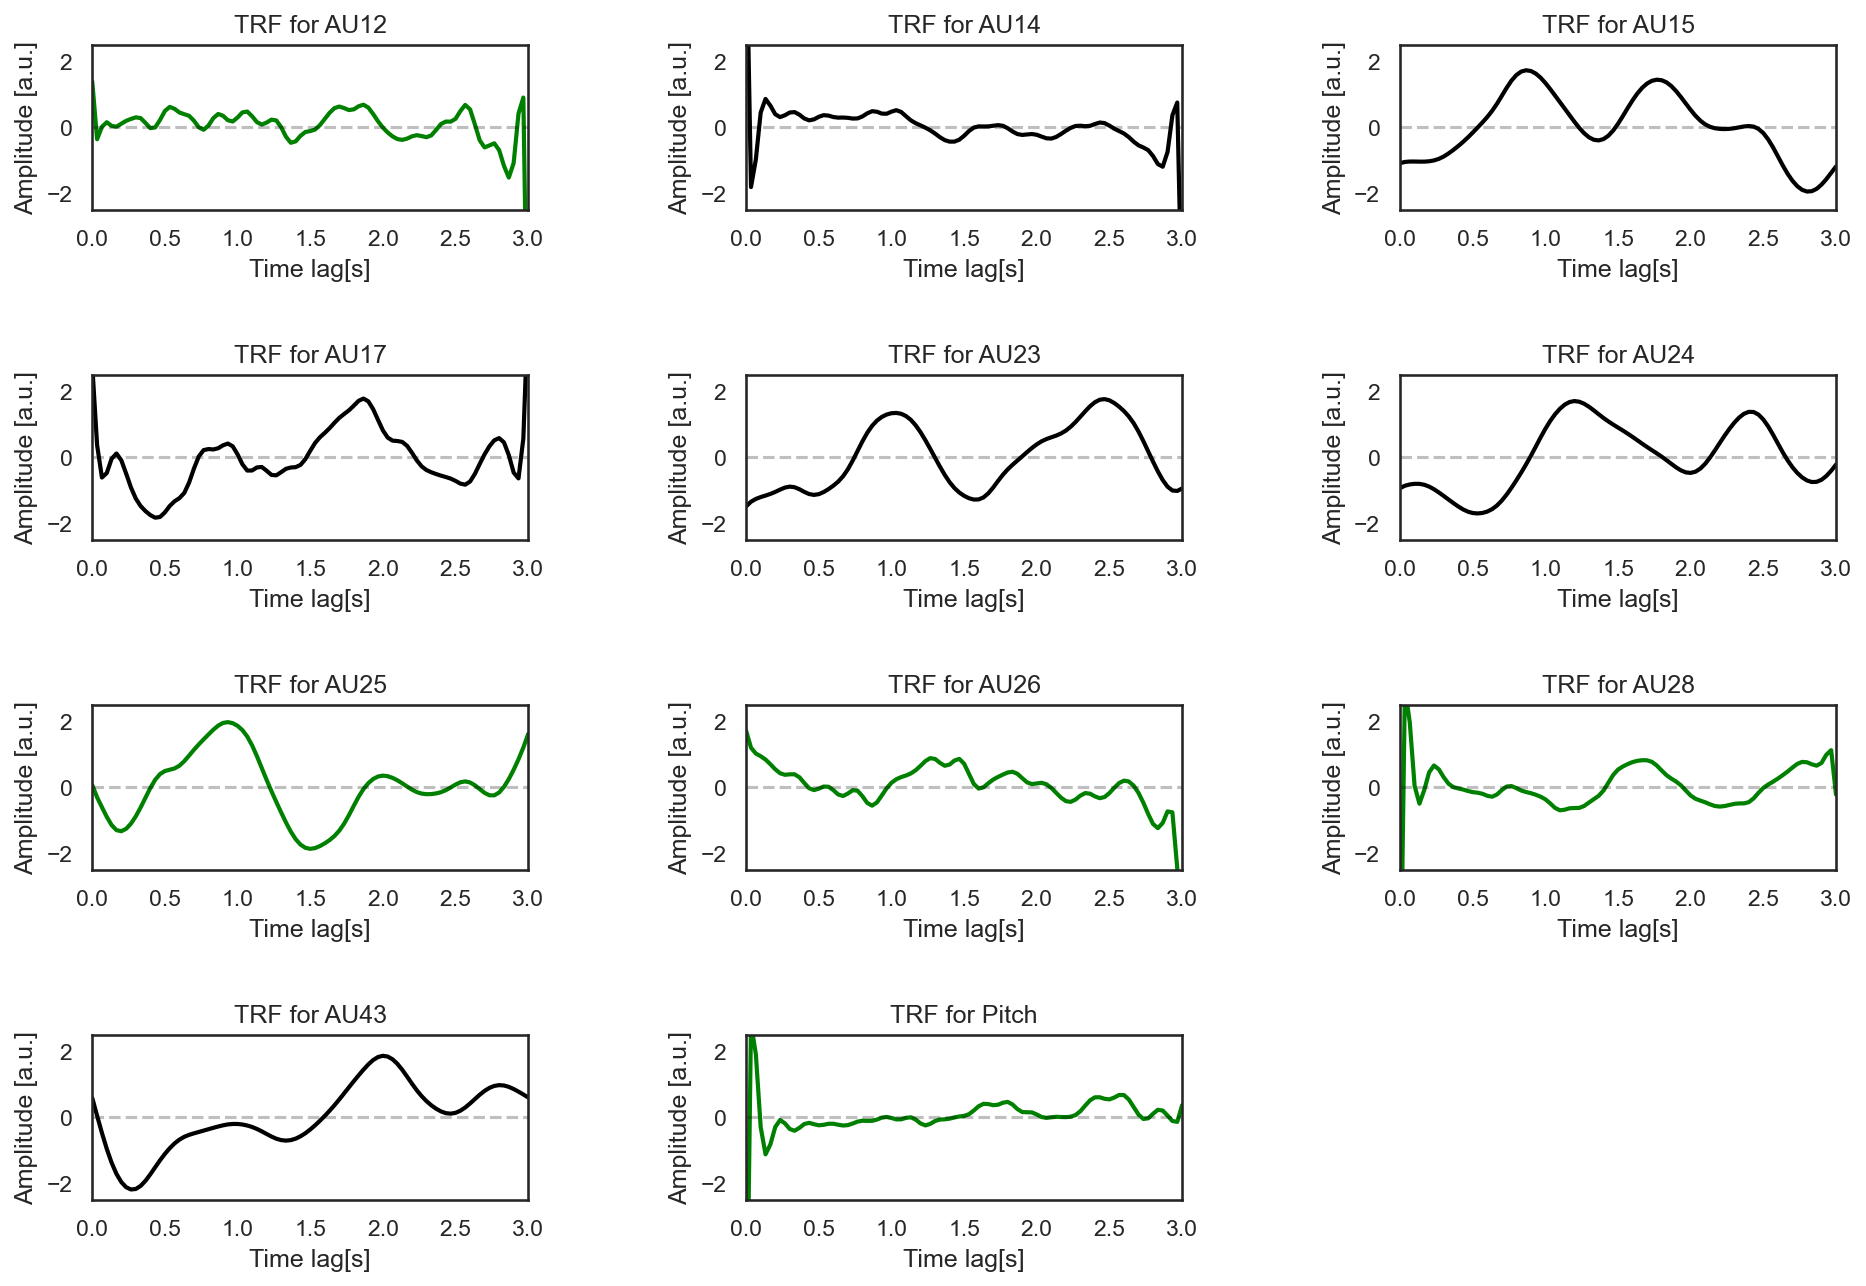

In [23]:
plt.figure(figsize=(15, 10))
plt.subplots_adjust(hspace=1, wspace=0.5)
for i, au_id in enumerate(store.get('aus')):
    ax = plt.subplot(4, 3, i + 1)
    plot_trf(direction=1, trf=trfs[i], axes=ax, show=False) 
    ax.set_title(f'TRF for {au_id}')
    if (i==0) or (i==6) or (i==6) or (i==7) or (i==8) or (i==10):
        ax.get_lines()[0].set_color("g")
    else:
        ax.get_lines()[0].set_color("k")

## t-test: TRF fits vs. Condition (True/Fake)

AU12
TtestResult(statistic=2.777913843482039, pvalue=0.006002518612851815, df=196.0)
*****************************************************************
AU14
TtestResult(statistic=1.6317556131975386, pvalue=0.10433662870415011, df=196.0)
*****************************************************************
AU15
TtestResult(statistic=1.6470921432858843, pvalue=0.10114141923666546, df=196.0)
*****************************************************************
AU17
TtestResult(statistic=1.836320093463324, pvalue=0.06782508168976151, df=196.0)
*****************************************************************
AU23
TtestResult(statistic=0.8992985822203403, pvalue=0.3695971494472563, df=196.0)
*****************************************************************
AU24
TtestResult(statistic=0.03478098072116329, pvalue=0.9722897822295651, df=196.0)
*****************************************************************
AU25
TtestResult(statistic=2.6242061375699026, pvalue=0.009369269111010894, df=196.0)
**********

Text(0, 0.5, 't')

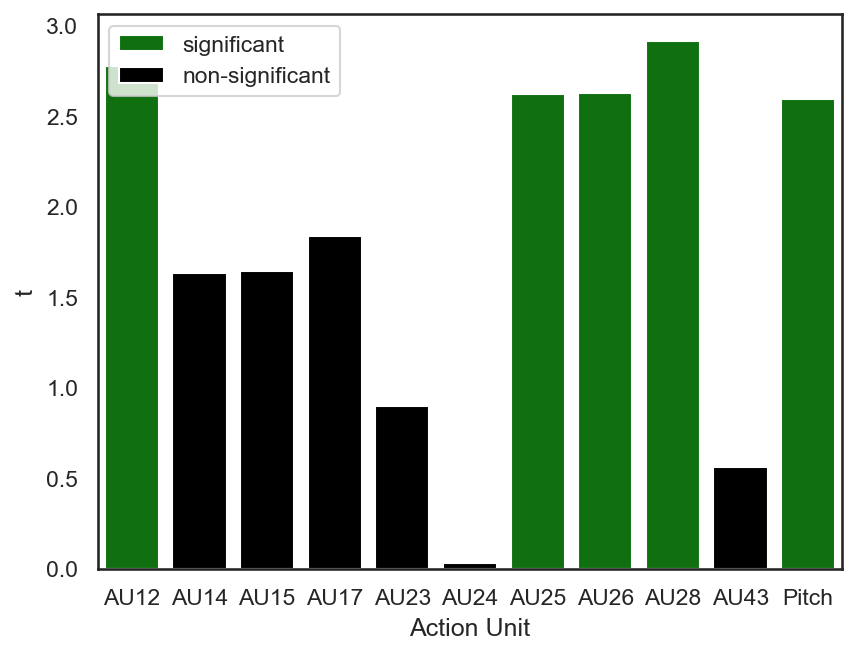

In [30]:
t_statistics = []
p_vals = []
for au in store.get('aus'):
    true_correlations = df_trials[(df_trials['AU']==au) & (df_trials['Condition']=='true')]['Pearsonr'].to_list()
    fake_correlations = df_trials[(df_trials['AU']==au) & (df_trials['Condition']=='fake')]['Pearsonr'].to_list()
    res = stats.ttest_ind(true_correlations, fake_correlations)
    t_statistics.append(res.statistic)
    p_vals.append(res.pvalue)
    print(au)
    print(res)
    print('*****************************************************************')

sig = ['significant' if p < 0.05 else 'non-significant' for p in p_vals]
sns.barplot(x=np.asarray(store.get('aus')), y=np.asarray(t_statistics), hue=sig, palette=['g', 'k'])
plt.xlabel('Action Unit')
plt.ylabel('t')

In [25]:
t_statistics

[2.777913843482039,
 1.6317556131975386,
 1.6470921432858843,
 1.836320093463324,
 0.8992985822203403,
 0.03478098072116329,
 2.6242061375699026,
 2.629416008472565,
 2.915392005603565,
 0.5635295738617861,
 2.594532835389616]

In [26]:
p_vals

[0.006002518612851815,
 0.10433662870415011,
 0.10114141923666546,
 0.06782508168976151,
 0.3695971494472563,
 0.9722897822295651,
 0.009369269111010894,
 0.00923182426325886,
 0.003966128739778537,
 0.5737184803885116,
 0.01018775589795083]

## SVM

In [ ]:
def get_training_data(data):
	feature_vector = []
	target_vector = []
	id_vector = []
	
	grouped_trials = data.groupby('VideoPath')
	
	for name, trial in grouped_trials:
		target_vector.append(trial['Condition'].to_list()[0])
		feature_vector.append(trial['Pearsonr'].to_list())
		id_vector.append(name)
		
	feature_vector = np.asarray(feature_vector)
	scaler = StandardScaler()
	scaled_features = scaler.fit_transform(feature_vector)
	
	target_vector = np.asarray(target_vector)
	
	return scaled_features, target_vector, id_vector


def nested_cv(features, targets):
	N_TRIALS = 10
	scores = np.zeros(N_TRIALS)

	svc = SVC(probability=True)
	param_grid = [{'C': np.logspace(-5, 3, 9), 'kernel':['linear']}]

	for i in range(N_TRIALS):
		inner_cv = KFold(n_splits=5, shuffle=True, random_state=i)
		outer_cv = KFold(n_splits=3, shuffle=True, random_state=i)

		model = GridSearchCV(estimator=svc, param_grid=param_grid, cv=inner_cv)
		model.fit(features, targets)

		test_score = cross_val_score(model, features, targets, cv=outer_cv)
		scores[i] = test_score.mean()

	return scores

In [ ]:
features, targets, ids = get_training_data(df_trials)
X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.5, random_state=1)

In [ ]:
scores = nested_cv(features, targets)

In [ ]:
print(f'Unbiased accuracy (using nested cross-validation): µ={np.asarray(scores).mean():.2f}, SD={np.asarray(scores).std():.2f}')
res = stats.ttest_1samp(scores, 0.5)
print_ttest(res, text='t-test for above chance accuracy')

sns.boxplot(data=scores, width=0.25, fill=False, color='k')
sns.stripplot(data=scores, alpha=0.25, color='k')
plt.axhline(y=0.5, color='k', ls='--')
plt.ylabel('SVM accuracy')
plt.xlabel('')
plt.xticks([])
plt.ylim(0, 1);

In [ ]:
svc = SVC(probability=True)
param_grid = [{'C': np.logspace(-5, 3, 9), 'kernel':['linear']}]
cv = KFold(n_splits=5, shuffle=True, random_state=1)
model = GridSearchCV(estimator=svc, param_grid=param_grid, cv=cv, n_jobs=-1)
model.fit(X_train, y_train)

final_clf = SVC(C=model.best_params_.get('C'), kernel='linear', probability=True)
final_clf.fit(X_train, y_train)
print(f'SVM accuracy: {final_clf.score(X_test, y_test):.2f}')

### Shapley values on SVM

In [ ]:
shap.initjs()

model_labels = final_clf.classes_
true_label_idx = np.argwhere(model_labels=='true')[0][0]
fake_label_idx = np.argwhere(model_labels=='fake')[0][0]

explainer = shap.Explainer(final_clf.predict_proba, X_train, feature_names=store.get('aus'))
shap_values = explainer(features)
shap.plots.beeswarm(shap_values[:, :, true_label_idx], max_display=11, show=False);

In [ ]:
from corr_shap import CorrExplainer

ex_empirical = CorrExplainer(final_clf.predict_proba, X_train, sampling="empirical", feature_names=store.get('aus'))
shap_empirical = ex_empirical(features)
shap.plots.beeswarm(shap_empirical[:, :, true_label_idx], show=False, max_display=11)

In [ ]:
shap.plots.bar(shap_empirical[:, :, true_label_idx], show=False, max_display=11)

# Behavioral x Computational

In [ ]:
acc = df[df['Block']==store.get('modality')].groupby('VideoPath', as_index=False)['Accuracy'].mean()
confidence = df[df['Block']==store.get('modality')].groupby('VideoPath', as_index=False)['LikertResp'].mean()
genuineness = df[df['Block']==store.get('modality')].groupby('VideoPath', as_index=False).apply(lambda x: pd.Series({'Genuineness': Counter(x['Resp'])['g']/len(x)}))

dfs = [acc, confidence, genuineness]
merged = pd.concat([df.set_index('VideoPath') for df in dfs], axis=1, join='inner').reset_index()

df_regression = pd.merge(merged, df_trials, 'inner', on='VideoPath')
df_regression['Pearsonr'] = df_regression['Pearsonr'].astype(float)

In [ ]:
def annotate(data, **kws):
	r, p = stats.pearsonr(data['Genuineness'], data['Pearsonr'])
	r2 = r2_score(data['Genuineness'], data['Pearsonr'],)
	ax = plt.gca()
	ax.text(.01, .8, 'r2={:.2f}, \np={:.2g}'.format(r2, p), color='g' if p < 0.05 else 'k', transform=ax.transAxes)

g = sns.lmplot(
            data=df_regression, 
            x='Pearsonr', 
            y='Genuineness', 
            col='AU', 
            col_wrap=4, 
            height=3, 
            aspect=1, 
            scatter_kws=dict(color="k", alpha=0.3), 
            line_kws=dict(color="k")
        )
g.map_dataframe(annotate)
plt.show()

In [ ]:
all_data = pd.read_csv('./stim/speed_dating_corpus/Speed Dating Data for R/all_data_df.csv')
all_data = all_data[(all_data['question']=='Q2') & (all_data['female_condition']=='U') & (all_data['male_condition']=='U')]
all_data = all_data[['participant_nb', 'interacting_partner', 'question_content', 'measure', 'N', 'sex', 'other_sex']]

df_regression = df_regression[['SpeakerID', 'ListenerID', 'DisplayedDyad', 'Accuracy', 'Genuineness', 'LikertResp']]
df_regression = df_regression.groupby('DisplayedDyad', as_index=False).agg('first')
df_regression = df_regression[df_regression['DisplayedDyad'].isin(all_data['N'].unique())].reset_index(drop=True)

In [ ]:
convo_gen = pd.merge(left=df_regression, right=all_data, how='inner', left_on='DisplayedDyad', right_on='N')
convo_gen = convo_gen[['N', 'participant_nb', 'interacting_partner', 'sex', 'other_sex', 'question_content', 'measure', 'Accuracy', 'Genuineness', 'LikertResp']]
convo_gen = convo_gen.groupby(['N', 'question_content'], as_index=False)[['measure', 'Accuracy', 'Genuineness', 'LikertResp']].mean()

In [ ]:
sns.regplot(data=convo_gen[convo_gen['question_content']=='good_conversation'], x='Genuineness', y='measure')
plt.ylabel('Rating of conversation quality')

## LM

In [ ]:
for au in df_regression['AU'].unique():
    model = Lm("Genuineness ~ Pearsonr", data=df_regression[df_regression['AU']==au])
    model.fit(summarize=False)
    if model.coefs.loc['Pearsonr']['P-val'] < 0.05:
        print('**********************************************************************')
        print(au)
        print(model.fit())

## GLM (logit)

In [ ]:
a = df[df['Block']==store.get('modality')][['Subject', 'VideoPath', 'Resp', 'Condition']]
b = df_trials[['VideoPath', 'AU', 'Pearsonr']]

a['AU'] = list(np.repeat(np.reshape(store.get('aus'), (1, -1)), len(a), axis=0))
a = a.explode(column=['AU'])

df_logit = pd.merge(a, b, 'inner', on=['VideoPath', 'AU'])
df_logit = df_logit.astype({'Resp': 'category', 'AU': 'string', 'Pearsonr': 'float'})

In [ ]:
for au in df_logit['AU'].unique():
    model = Lmer("Resp ~ Pearsonr + (1|Subject)", family='binomial', data=df_logit[df_logit['AU']==au])
    model.fit(summarize=False)
    if model.coefs.loc['Pearsonr']['P-val'] < 0.05:
        print('**********************************************************************')
        print(au)
        print(model.fit())

## SVR

### Shapley values on SVR

## TRF fit vs. SDT category

In [ ]:
a = df[df['Block']=='va'][['Subject', 'VideoPath', 'Resp', 'Condition', 'LikertResp']]
b = df_trials[['VideoPath', 'AU', 'Pearsonr']]

a['AU'] = list(np.repeat(np.reshape(store.get('aus'), (1, -1)), len(a), axis=0))
a = a.explode(column=['AU'])

df_logit = pd.merge(a, b, 'inner', on=['VideoPath', 'AU'])
df_logit = df_logit.astype({'Resp': 'category', 'AU': 'string', 'Pearsonr': 'float'})

In [ ]:
def sdt_cat(pair):
    match pair:
        case ('true', 'g'):
            return 'hit'
        case ('true', 'h'):
            return 'miss'
        case ('fake', 'g'):
            return 'fa'
        case ('fake', 'h'):
            return 'cr'

    
def mod_mode(fa, likert):
    data = list(zip(fa, likert))
    agg_data = defaultdict(list)
    for k, v in data:
        agg_data[k].append(v)   

    if len(agg_data) == 1:
        mode = list(agg_data.keys())[0]
    else:
        conf_g = np.mean(agg_data.get('g')) * len(agg_data.get('g'))
        conf_h = np.mean(agg_data.get('h')) * len(agg_data.get('h'))
        if conf_g > conf_h:
            mode = 'g'
        elif conf_g < conf_h:
            mode = 'h'
        else:
            mode = random.choice(['g', 'h'])

    return mode


df_logit = df_logit.groupby(['VideoPath', 'AU'], as_index=False).agg({'Resp': list, 'LikertResp': list, 'Condition': 'first', 'Pearsonr': 'first'})
df_logit['WM'] = df_logit.apply(lambda x: mod_mode(x['Resp'], x['LikertResp']), axis=1)
df_logit['SDT'] = df_logit.apply(lambda x: sdt_cat((x['Condition'], x['WM'])), axis=1)

In [ ]:
model_preds = final_clf.predict(features)
model_preds = ['g' if pred == 'true' else 'h' for pred in model_preds]

model_sdt = pd.DataFrame({'VideoPath': ids, 'SVMResp': model_preds})
df_last = pd.merge(model_sdt, df_logit, 'inner', on='VideoPath')
df_last['SVM_SDT'] = df_last.apply(lambda x: sdt_cat((x['Condition'], x['SVMResp'])), axis=1)

### Participants

In [ ]:
sns.barplot(
                data=df_last[(df_last['AU']=='AU25') | (df_last['AU']=='AU43')],
                x='SDT',
                y='Pearsonr',
                hue='AU',
                order=['hit', 'miss', 'cr', 'fa'],
                fill=False,
                gap=0.15
            )
plt.ylabel('TRF fits')
plt.xlabel('')
plt.ylim(-0.15, 0.2);

### Model

In [ ]:
sns.barplot(
                data=df_last[(df_last['AU']=='AU25') | (df_last['AU']=='AU43')],
                x='SVM_SDT',
                y='Pearsonr',
                hue='AU',
                order=['hit', 'miss', 'cr', 'fa'],
                fill=False,
                gap=0.15
            )
plt.ylabel('TRF fits')
plt.xlabel('');